In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals
import re
import os
import codecs
import json
import csv
import spacy
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors.nearest_centroid import NearestCentroid

In [3]:
nlp=spacy.load('en')

In [4]:
intent_dict_AskUbuntu = {"Make Update":0, "Setup Printer":1, "Shutdown Computer":2, "Software Recommendation":3, "None":4}
intent_dict_Chatbot = {"DepartureTime":0, "FindConnection":1}
intent_dict_WebApplications = {"Download Video":0, "Change Password":1, "None":2, "Export Data":3, "Sync Accounts":4,
                  "Filter Spam":5, "Find Alternative":6, "Delete Account":7}

In [5]:
benchmark_dataset = 'WebApplication' #choose from 'AskUbuntu', 'Chatbot' or 'WebApplications'

In [6]:
filename_train = "datasets/KL/" + benchmark_dataset + "/train.csv"
filename_test = "datasets/KL/" + benchmark_dataset + "/test.csv"

In [7]:
def read_CSV_datafile(filename):    
    X = []
    y = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            X.append(row[0])
            if benchmark_dataset == 'AskUbuntu':
                y.append(intent_dict_AskUbuntu[row[1]])
            elif benchmark_dataset == 'Chatbot':
                y.append(intent_dict_Chatbot[row[1]])
            else:
                y.append(intent_dict_WebApplications[row[1]])           
    return X,y

In [8]:
X_train_raw, y_train_raw = read_CSV_datafile(filename = filename_train)
X_test_raw, y_test_raw = read_CSV_datafile(filename = filename_test)

In [9]:
print("Training data samples: \n",X_train_raw[-5:-1], "\n\n")

print("Class Labels: \n", y_train_raw[-5:-1], "\n\n")

print("Size of Training Data: {}".format(len(X_train_raw)))

Training data samples: 
 ['hoc to disable/delete a harvest account?', 'how tz disable/delete a harvest account?', 'how to disable/delete a harvekt account?', 'how to wisable/delete a harvest account?'] 


Class Labels: 
 [7, 7, 7, 7] 


Size of Training Data: 1556


In [10]:
def tokenize(doc):
    """
    Returns a list of strings containing each token in `sentence`
    """
    #return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])",
    #                            doc) if i != '' and i != ' ' and i != '\n']
    tokens = []
    doc = nlp.tokenizer(doc)
    for token in doc:
        tokens.append(token.text)
    return tokens



In [11]:
def preprocess(doc):
    clean_tokens = []
    doc = nlp(doc)
    for token in doc:
        if not token.is_stop:
            clean_tokens.append(token.lemma_)
    return " ".join(clean_tokens)

In [12]:
def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

def semhash_tokenizer(text):
    tokens = text.split(" ")
    final_tokens = []
    for unhashed_token in tokens:
        hashed_token = "#{}#".format(unhashed_token)
        final_tokens += [''.join(gram)
                         for gram in list(find_ngrams(list(hashed_token), 3))]
    return final_tokens

def semhash_corpus(corpus):
    new_corpus = []
    for sentence in corpus:
        sentence = preprocess(sentence)
        tokens = semhash_tokenizer(sentence)
        new_corpus.append(" ".join(map(str,tokens)))
    return new_corpus

X_train_raw = semhash_corpus(X_train_raw)
X_test_raw = semhash_corpus(X_test_raw)

In [13]:
X_train_raw[:5]

['#do dow own wnl nlh lha had ad# #xo xou out utu tub ube be# #vi vid ide deo eo# #?#',
 '#do dow own wnl nlo loa oad ad# #yh yhu hut utu tub ube be# #vi vid ide deo eo# #?#',
 '#d# #do dow own wnl nlo loa oad ad# #yo you out utu tub ubi bi# #vi vid ide deo eo# #?#',
 '#vo vo# #do dow own wnl nlo loa oad ad# #yo you out utu tub ube be# #vi vid ide deo eo# #?#',
 '#do dow own wnl nlo loa oad ad# #yo you out utu tui uie ie# #vi vid ide deo eo# #?#']

In [14]:
def get_vectorizer(corpus, preprocessor=None, tokenizer=None):
    vectorizer = CountVectorizer(ngram_range=(2,4),analyzer='char')
    vectorizer.fit(corpus)
    return vectorizer, vectorizer.get_feature_names()

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.neural_network import MLPClassifier

In [16]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf, X_train, y_train, X_test, y_test, target_names,
              print_report=True, feature_names=None, print_top10=False,
              print_cm=True):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    #print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                  "Filter Spam", "Find Alternative", "Delete Account"]):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join([feature_names[i] for i in top10]))))
        print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [17]:
def plot_results(results):
    # make some plots
    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    plt.savefig("./results_AskUbuntu.png", format="png")
    plt.show()

In [18]:
def data_for_training():
    vectorizer, feature_names = get_vectorizer(X_train_raw, preprocessor=preprocess, tokenizer=tokenize)
    
    X_train = vectorizer.transform(X_train_raw).toarray()
    X_test = vectorizer.transform(X_test_raw).toarray()
            
    return X_train, y_train_raw, X_test, y_test_raw, feature_names

Evaluating Split 0
Train Size: 1556
Test Size: 59
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 40, 50, 100, 70], 'min_samples_leaf': [1, 3, 5, 11, 25], 'max_features': [0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
train time: 987.637s
test time:  0.005s
accuracy:   0.763
classification report:
            

/home/insideout/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


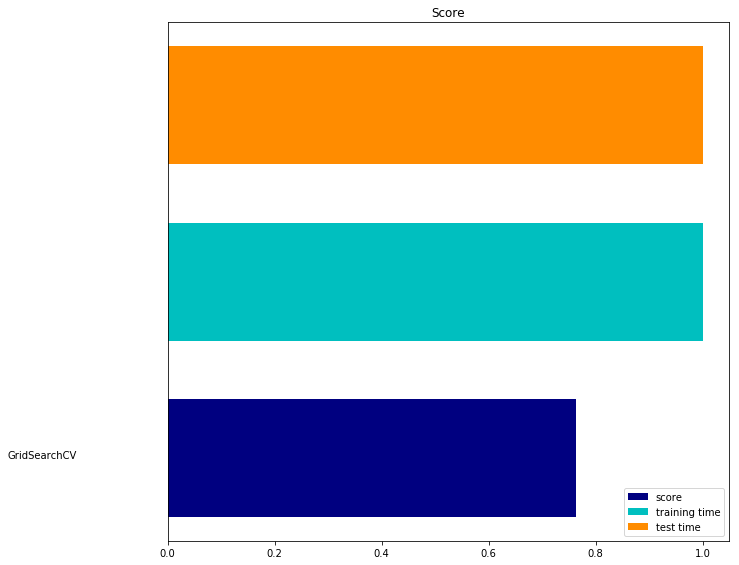

In [23]:
import matplotlib.pyplot as plt
for i_s, split in enumerate(range(1)):
    print("Evaluating Split {}".format(i_s))
    X_train, y_train, X_test, y_test, feature_names = data_for_training()
    #target_names = ["DepartureTime","FindConnection"]
    target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                  "Filter Spam", "Find Alternative", "Delete Account"]
    print("Train Size: {}\nTest Size: {}".format(X_train.shape[0], X_test.shape[0]))
    results = []
    
    parameters_RF={ "n_estimators" : [10,20,40,50,100,70],
           "min_samples_leaf" : [1,3,5,11,25],
                  "max_features" : [0.5,1]}
    
    for clf, name in [ 
        (GridSearchCV(RandomForestClassifier(),parameters_RF, cv=5),"gridsearchRF")
        ]:
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))
        
        plot_results(results)

Evaluating Split 0
Train Size: 1556
Test Size: 59
gridsearchmlp
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise',
       estimator=MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(100, 50), (300, 100), (300, 200, 100)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
train time: 131.982s
test time:  0.007s
accuracy:   0.780
classification report:
                  precision    recall  f1-

/home/insideout/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


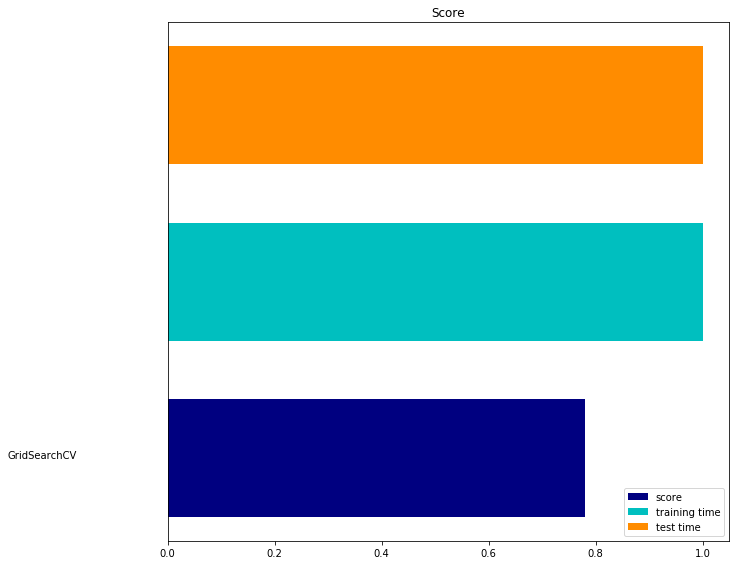

In [28]:
import matplotlib.pyplot as plt
for i_s, split in enumerate(range(1)):
    print("Evaluating Split {}".format(i_s))
    X_train, y_train, X_test, y_test, feature_names = data_for_training()
    #target_names = ["DepartureTime","FindConnection"]
    target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                  "Filter Spam", "Find Alternative", "Delete Account"]
    print("Train Size: {}\nTest Size: {}".format(X_train.shape[0], X_test.shape[0]))
    results = []
    parameters_mlp={'hidden_layer_sizes':[(100,50), (300, 100),(300,200,100)]}
    for clf, name in [
        (GridSearchCV(MLPClassifier(activation='tanh'),parameters_mlp, cv=5),"gridsearchmlp")
        ]:
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))
        
        plot_results(results)
        
        